In [51]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint
# Import and read charity_data.csv
import pandas as pd 
application_df = pd.read_csv("C:/Users/andca/Class/Neural_Network_Charity_Analysis/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [52]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=["EIN", "NAME"], axis=1)
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [53]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [54]:
# Look at APPLICATION_TYPE value counts for binning
application_counts = application_df["APPLICATION_TYPE"].value_counts()
application_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

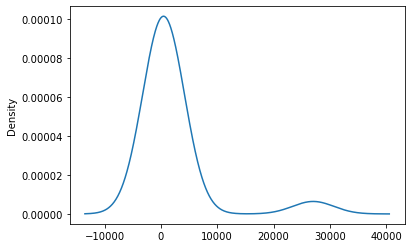

In [55]:
# Visualize the value counts of APPLICATION_TYPE
application_counts.plot.density()

In [56]:
# Determine which values to replace if counts are less than 500
replace_application = list(application_counts[application_counts < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df["APPLICATION_TYPE"] = application_df["APPLICATION_TYPE"].replace(app, "Other")

# Bucket CLASSIFICATION
classification_counts = application_df["CLASSIFICATION"].value_counts()

In [57]:
# Determine which values to replace if counts are less than ..?
replace_class = list(classification_counts[classification_counts < 1500].index)
# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
classification_counts = application_df.CLASSIFICATION.value_counts()
classification_counts

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [58]:
# Determine which values to replace if counts are less than 1800
replace_class = list(classification_counts[classification_counts < 1800].index)

# Replace in dataframe
for cls in replace_class:
    application_df["CLASSIFICATION"] = application_df["CLASSIFICATION"].replace(cls, "Other")

# Generate our categorical variable lists
application_cat = list(application_df.dtypes[application_df.dtypes == "object"].index)

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)

# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(labels=application_cat, axis=1)

C:\Users\andca\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [59]:
# Split the preprocessed data into features and target arrays
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop(['IS_SUCCESSFUL'], 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

C:\Users\andca\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [61]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
# number of layer1 neurons 
hidden_nodes_layer1 = 100
# number of layer2 neurons
hidden_nodes_layer2 = 30

nn_inc_epochs = tf.keras.models.Sequential()

# First hidden layer
nn_inc_epochs.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn_inc_epochs.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn_inc_epochs.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_inc_epochs.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               4400      
                                                                 
 dense_13 (Dense)            (None, 30)                3030      
                                                                 
 dense_14 (Dense)            (None, 1)                 31        
                                                                 
Total params: 7,461
Trainable params: 7,461
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Compile the model
nn_inc_epochs.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [67]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimization_add_neurons/", exist_ok=True)
checkpoint_path = "checkpoints_optimization_add_neurons/weights.{epoch:02d}hdf5"

In [64]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=0,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_model_inc_epochs = nn_inc_epochs.fit(X_train_scaled, y_train, epochs=200)

Epoch 1/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5683 - accuracy: 0.7245
Epoch 2/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5552 - accuracy: 0.7313
Epoch 3/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5517 - accuracy: 0.7315
Epoch 4/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5506 - accuracy: 0.7319
Epoch 5/200
804/804 [==============================] - 1s 985us/step - loss: 0.5489 - accuracy: 0.7336
Epoch 6/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5484 - accuracy: 0.7334
Epoch 7/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5477 - accuracy: 0.7330
Epoch 8/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5469 - accuracy: 0.7346
Epoch 9/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5466 - accuracy: 0.7350
Epoch 10/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5460 - accu

804/804 [==============================] - 1s 990us/step - loss: 0.5362 - accuracy: 0.7407
Epoch 80/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5361 - accuracy: 0.7406
Epoch 81/200
804/804 [==============================] - 1s 910us/step - loss: 0.5365 - accuracy: 0.7410
Epoch 82/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5365 - accuracy: 0.7400
Epoch 83/200
804/804 [==============================] - 1s 925us/step - loss: 0.5361 - accuracy: 0.7398
Epoch 84/200
804/804 [==============================] - 1s 978us/step - loss: 0.5362 - accuracy: 0.7401
Epoch 85/200
804/804 [==============================] - 1s 960us/step - loss: 0.5361 - accuracy: 0.7419
Epoch 86/200
804/804 [==============================] - 1s 978us/step - loss: 0.5361 - accuracy: 0.7402
Epoch 87/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5360 - accuracy: 0.7409
Epoch 88/200
804/804 [==============================] - 1s 952us/step - loss: 0.536

804/804 [==============================] - 1s 960us/step - loss: 0.5338 - accuracy: 0.7418
Epoch 159/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5335 - accuracy: 0.7415
Epoch 160/200
804/804 [==============================] - 1s 911us/step - loss: 0.5336 - accuracy: 0.7416
Epoch 161/200
804/804 [==============================] - 1s 941us/step - loss: 0.5339 - accuracy: 0.7416
Epoch 162/200
804/804 [==============================] - 1s 958us/step - loss: 0.5333 - accuracy: 0.7416
Epoch 163/200
804/804 [==============================] - 1s 953us/step - loss: 0.5338 - accuracy: 0.7419
Epoch 164/200
804/804 [==============================] - 1s 973us/step - loss: 0.5336 - accuracy: 0.7419
Epoch 165/200
804/804 [==============================] - 1s 950us/step - loss: 0.5338 - accuracy: 0.7421
Epoch 166/200
804/804 [==============================] - 1s 983us/step - loss: 0.5334 - accuracy: 0.7416
Epoch 167/200
804/804 [==============================] - 1s 986us/step 

In [68]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_inc_epochs.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5707 - accuracy: 0.7256 - 367ms/epoch - 1ms/step
Loss: 0.5707436203956604, Accuracy: 0.7255976796150208


In [15]:
### Changing activation function

In [16]:
# Changing Activation Function: try tanh to handle negative inputs in X_train_scaled
nn_tanh = tf.keras.models.Sequential()

# First hidden layer
nn_tanh.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="tanh"))

# Second hidden layer
nn_tanh.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="tanh"))

# Output layer
nn_tanh.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_tanh.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               4400      
                                                                 
 dense_4 (Dense)             (None, 30)                3030      
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 7,461
Trainable params: 7,461
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile the model
nn_tanh.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
fit_model_tanh = nn_tanh.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5714 - accuracy: 0.7223
Epoch 2/100
804/804 [==============================] - 1s 944us/step - loss: 0.5564 - accuracy: 0.7280
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5530 - accuracy: 0.7315
Epoch 4/100
804/804 [==============================] - 1s 869us/step - loss: 0.5510 - accuracy: 0.7306
Epoch 5/100
804/804 [==============================] - 1s 889us/step - loss: 0.5498 - accuracy: 0.7324
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5486 - accuracy: 0.7331
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5477 - accuracy: 0.7331
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5469 - accuracy: 0.7331
Epoch 9/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5466 - accuracy: 0.7338
Epoch 10/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5452 - 

804/804 [==============================] - 1s 1ms/step - loss: 0.5327 - accuracy: 0.7415
Epoch 81/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5328 - accuracy: 0.7416
Epoch 82/100
804/804 [==============================] - 1s 963us/step - loss: 0.5325 - accuracy: 0.7421
Epoch 83/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5325 - accuracy: 0.7420
Epoch 84/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5326 - accuracy: 0.7428
Epoch 85/100
804/804 [==============================] - 1s 945us/step - loss: 0.5323 - accuracy: 0.7423
Epoch 86/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5323 - accuracy: 0.7428
Epoch 87/100
804/804 [==============================] - 1s 995us/step - loss: 0.5327 - accuracy: 0.7420
Epoch 88/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5323 - accuracy: 0.7428
Epoch 89/100
804/804 [==============================] - 1s 929us/step - loss: 0.5324 - ac

In [65]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_tanh.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5547 - accuracy: 0.7235 - 228ms/epoch - 851us/step
Loss: 0.5546519160270691, Accuracy: 0.723498523235321


In [69]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=0,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_model = nn_tanh.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback], verbose=1)

Epoch 1/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5319 - accuracy: 0.7427
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5319 - accuracy: 0.7418
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5318 - accuracy: 0.7428
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5320 - accuracy: 0.7427
Epoch 5/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5319 - accuracy: 0.7417
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5318 - accuracy: 0.7423
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5321 - accuracy: 0.7422
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5322 - accuracy: 0.7425
Epoch 9/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5316 - accuracy: 0.7425
Epoch 10/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5317 - accura

804/804 [==============================] - 1s 1ms/step - loss: 0.5306 - accuracy: 0.7421
Epoch 81/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5307 - accuracy: 0.7427
Epoch 82/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5308 - accuracy: 0.7429
Epoch 83/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5306 - accuracy: 0.7421
Epoch 84/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5308 - accuracy: 0.7429
Epoch 85/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5304 - accuracy: 0.7427
Epoch 86/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5306 - accuracy: 0.7437
Epoch 87/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5307 - accuracy: 0.7430
Epoch 88/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5305 - accuracy: 0.7427
Epoch 89/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5303 - accuracy: 

In [71]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_tanh.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5570 - accuracy: 0.7241 - 243ms/epoch - 906us/step
Loss: 0.5569762587547302, Accuracy: 0.7240816354751587


In [72]:
### Adding more hidden layers

In [78]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
nodes_hidden_layer1 = 80
nodes_hidden_layer2 = 30
nodes_hidden_layer3 = 10

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer1, activation="relu", input_dim=number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 80)                3520      
                                                                 
 dense_20 (Dense)            (None, 30)                2430      
                                                                 
 dense_21 (Dense)            (None, 20)                620       
                                                                 
 dense_22 (Dense)            (None, 1)                 21        
                                                                 
Total params: 6,591
Trainable params: 6,591
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [80]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimization_add_layer/", exist_ok=True)
checkpoint_path = "checkpoints_optimization_add_layer/weights.{epoch:02d}hdf5"

In [81]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=0,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback], verbose=1)

Epoch 1/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5692 - accuracy: 0.7237
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5537 - accuracy: 0.7309
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5508 - accuracy: 0.7321
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5490 - accuracy: 0.7337
Epoch 5/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5487 - accuracy: 0.7339
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5480 - accuracy: 0.7345
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5474 - accuracy: 0.7341
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5468 - accuracy: 0.7362
Epoch 9/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5462 - accuracy: 0.7352
Epoch 10/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5463 - accura

804/804 [==============================] - 1s 1ms/step - loss: 0.5356 - accuracy: 0.7406
Epoch 81/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5362 - accuracy: 0.7409
Epoch 82/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5364 - accuracy: 0.7409
Epoch 83/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5358 - accuracy: 0.7405
Epoch 84/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5355 - accuracy: 0.7403
Epoch 85/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5358 - accuracy: 0.7400
Epoch 86/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5355 - accuracy: 0.7407
Epoch 87/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5358 - accuracy: 0.7406
Epoch 88/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5354 - accuracy: 0.7404
Epoch 89/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5357 - accuracy: 

In [82]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5550 - accuracy: 0.7248 - 300ms/epoch - 1ms/step
Loss: 0.5550164580345154, Accuracy: 0.724781334400177
